In [1]:
# all imports here
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from itertools import combinations

In [ ]:
DATA_DIR = Path("/Users/naranjan/Documents/IAQFF")


OHLC_FILES = {
    ("bnus", "BTC/USD"):  "ohlcv_1s_bnus_btc-usd.csv",
    ("bnus", "BTC/USDT"): "ohlcv_1s_bnus_btc-usdt.csv",
    ("bnus", "BTC/USDC"): "ohlcv_1s_bnus_btc-usdc.csv",
    ("cbse", "BTC/USD"):  "ohlcv_1s_cbse_btc-usd.csv",
    ("cbse", "BTC/USDT"): "ohlcv_1s_cbse_btc-usdt.csv",
    ("krkn", "BTC/USD"): "ohlcv_1s_krkn_btc-usd.csv",
    ("krkn", "BTC/USDT"): "ohlcv_1s_krkn_btc-usdt.csv",
    ("krkn", "BTC/USDC"): "ohlcv_1s_krkn_btc-usdc.csv",
}

TRADE_FILES = {
    ("bnus", "BTC/USD"):  "trades_bnus_btc-usd.csv",
    ("bnus", "BTC/USDT"): "trades_bnus_btc-usdt.csv",
    ("bnus", "BTC/USDC"): "trades_bnus_btc-usdc.csv",
    ("cbse", "BTC/USD"):  "trades_cbse_btc-usd.csv",
    ("cbse", "BTC/USDT"): "trades_cbse_btc-usdt.csv",
    ("krkn", "BTC/USD"): "trades_krkn_btc-usd.csv",
    ("krkn", "BTC/USDT"): "trades_krkn_btc-usdt.csv",
    ("krkn", "BTC/USDC"): "trades_krkn_btc-usdc.csv",
}

PAIR_FOCUS = ["BTC/USD", "BTC/USDT", "BTC/USDC"]

PAIR_VENUE_MAP = {
    "BTC/USD": ["bnus", "cbse", "krkn"],
    "BTC/USDT": ["bnus", "cbse", "krkn"],
    "BTC/USDC": ["bnus", "krkn"],
}

In [ ]:
def explain_block(title, data_used, how_to_gauge):
    print("\n" + "=" * 90)
    print(title)
    print(f"Data used: {data_used}")
    print(f"How to gauge: {how_to_gauge}")
    print("=" * 90 + "\n")
    
def add_regime_labels(df, ts_col=None):
    out = df.copy()

    if ts_col is not None:
        t = pd.to_datetime(out[ts_col], utc=True, errors="coerce")
        d = t.dt.normalize()   
    else:
        t = pd.to_datetime(out.index, utc=True, errors="coerce")
        d = t.normalize()

    out["regime"] = np.select(
        [
            (d >= pd.Timestamp("2023-03-01", tz="UTC")) & (d <= pd.Timestamp("2023-03-09", tz="UTC")),
            (d >= pd.Timestamp("2023-03-10", tz="UTC")) & (d <= pd.Timestamp("2023-03-14", tz="UTC")),
            (d >= pd.Timestamp("2023-03-15", tz="UTC")) & (d <= pd.Timestamp("2023-03-21", tz="UTC")),
        ],
        ["calm", "stress", "post_crash"],
        default="out_of_scope",
    )
    return out


In [4]:
def load_ohlc_one(path, exchange, pair):
    df = pd.read_csv(path)
    df["ts"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors="coerce")
    for c in ["open", "high", "low", "close"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    vol_col = "volume" if "volume" in df.columns else ("volume_traded" if "volume_traded" in df.columns else None)
    df["volume"] = pd.to_numeric(df[vol_col], errors="coerce") if vol_col else np.nan

    df = df.dropna(subset=["ts", "close"]).sort_values("ts").set_index("ts")
    df["exchange"] = exchange
    df["pair"] = pair
    return add_regime_labels(df)

def load_trades_one(path, exchange, pair):
    df = pd.read_csv(path)
    df["ts"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors="coerce")
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    amount_col = "amount" if "amount" in df.columns else ("size" if "size" in df.columns else None)
    if amount_col is None:
        raise ValueError(f"No amount/size column in {path}")
    df["amount"] = pd.to_numeric(df[amount_col], errors="coerce")

    if "taker_side_sell" in df.columns:
        raw = df["taker_side_sell"]
        is_sell = raw if raw.dtype == bool else raw.astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False}).fillna(False)
        df["sign"] = np.where(is_sell, -1.0, 1.0)
    else:
        df["sign"] = np.nan

    df = df.dropna(subset=["ts", "price", "amount"]).sort_values("ts").set_index("ts")
    df["exchange"] = exchange
    df["pair"] = pair
    return add_regime_labels(df)

def load_all(ohlc_files, trade_files):
    ohlc_list, tr_list, missing = [], [], []

    for (ex, pair), fn in ohlc_files.items():
        p = DATA_DIR / fn
        if p.exists():
            ohlc_list.append(load_ohlc_one(p, ex, pair))
        else:
            missing.append(fn)

    for (ex, pair), fn in trade_files.items():
        p = DATA_DIR / fn
        if p.exists():
            tr_list.append(load_trades_one(p, ex, pair))
        else:
            missing.append(fn)

    ohlc = pd.concat(ohlc_list).sort_index() if ohlc_list else pd.DataFrame()
    trades = pd.concat(tr_list).sort_index() if tr_list else pd.DataFrame()
    return ohlc, trades, sorted(set(missing))

ohlc_all, trades_all, missing_files = load_all(OHLC_FILES, TRADE_FILES)
print("OHLC rows:", len(ohlc_all), "| Trades rows:", len(trades_all))
print("Missing files:", missing_files if missing_files else "None")

OHLC rows: 3367917 | Trades rows: 16962676
Missing files: None


In [5]:
def resample_ohlc_1m(df):
    g = df.resample("1min")
    out = pd.DataFrame({
        "open": g["open"].first(),
        "high": g["high"].max(),
        "low": g["low"].min(),
        "close": g["close"].last(),
        "volume": g["volume"].sum(),
    }).dropna(subset=["close"])
    return add_regime_labels(out)

def resample_trades_1m(df):
    x = df.copy()
    x["dollar"] = x["price"] * x["amount"]
    x["signed_dollar"] = x["sign"] * x["dollar"]

    out = pd.DataFrame({
        "vwap": x["dollar"].resample("1min").sum() / x["amount"].resample("1min").sum(),
        "last": x["price"].resample("1min").last(),
        "vol_dollar": x["dollar"].resample("1min").sum(),
        "n_trades": x["price"].resample("1min").count(),
        "signed_dollar": x["signed_dollar"].resample("1min").sum(),
    })
    out["ret"] = np.log(out["vwap"]).diff()
    out = out.dropna(subset=["vwap", "ret"])
    return add_regime_labels(out)

In [ ]:

# Volume Fragmentation (3-venue + 2-venue map)

explain_block(
    "Volume Fragmentation (HHI + venue shares + dominance shifts).",
    "Trades data, 1-minute bins, volume=amount. Pairs: BTC/USD & BTC/USDT across bnus/cbse/krkn; BTC/USDC across bnus/krkn.",
    "Higher HHI = more concentration. Dominance shift is significant only if >5 percentage points."
)

PAIR_VENUE_MAP = {
    "BTC/USD": ["bnus", "cbse", "krkn"],
    "BTC/USDT": ["bnus", "cbse", "krkn"],
    "BTC/USDC": ["bnus", "krkn"],
}

def volume_fragmentation_multi(trades_df, pair_venue_map, freq="1min", sig_pp=5.0):
    hhi_all, share_all = [], []

    for pair, venues in pair_venue_map.items():
        d = trades_df[(trades_df["pair"] == pair) & (trades_df["exchange"].isin(venues))].copy()
        d["time_bin"] = d.index.floor(freq)

        # per-minute venue volume
        vv = d.groupby(["time_bin", "exchange"], as_index=False)["amount"].sum().rename(columns={"amount": "venue_vol"})

        # full grid (avoid missing-minute bias)
        minutes = pd.date_range("2023-03-01", "2023-03-21 23:59:00", freq=freq, tz="UTC")
        grid = pd.MultiIndex.from_product([minutes, venues], names=["time_bin", "exchange"]).to_frame(index=False)
        vv = grid.merge(vv, on=["time_bin", "exchange"], how="left").fillna({"venue_vol": 0.0})

        tot = vv.groupby("time_bin", as_index=False)["venue_vol"].sum().rename(columns={"venue_vol": "total_vol"})
        s = vv.merge(tot, on="time_bin", how="left")
        s["share"] = np.where(s["total_vol"] > 0, s["venue_vol"] / s["total_vol"], np.nan)
        s["pair"] = pair
        s = add_regime_labels(s, ts_col="time_bin")
        s = s[s["regime"] != "out_of_scope"]
        share_all.append(s)

        h = s.groupby(["pair", "time_bin"], as_index=False)["share"].apply(lambda x: np.nansum(np.square(x))).rename(columns={"share": "hhi"})
        h = add_regime_labels(h, ts_col="time_bin")
        h = h[h["regime"] != "out_of_scope"]
        hhi_all.append(h)

    shares_df = pd.concat(share_all, ignore_index=True)
    hhi_ts_df = pd.concat(hhi_all, ignore_index=True)

    hhi_summary = (
        hhi_ts_df.groupby(["pair", "regime"], as_index=False)["hhi"]
        .agg(mean_hhi="mean", median_hhi="median", p90_hhi=lambda x: np.nanpercentile(x, 90), n_bins="count")
        .sort_values(["pair", "regime"])
    )

    share_summary = (
        shares_df.groupby(["pair", "regime", "exchange"], as_index=False)["share"]
        .mean()
        .rename(columns={"share": "mean_share"})
        .sort_values(["pair", "regime", "exchange"])
    )

    # dominant venue + significance vs calm
    dom = share_summary.loc[share_summary.groupby(["pair", "regime"])["mean_share"].idxmax()].copy()
    dom = dom.rename(columns={"exchange": "dominant_exchange", "mean_share": "dominant_share"})
    calm_ref = dom[dom["regime"] == "calm"][["pair", "dominant_exchange", "dominant_share"]].rename(
        columns={"dominant_exchange": "calm_dominant_exchange", "dominant_share": "calm_dominant_share"}
    )
    dom = dom.merge(calm_ref, on="pair", how="left")
    dom["delta_vs_calm_pp"] = (dom["dominant_share"] - dom["calm_dominant_share"]) * 100
    dom["significance"] = np.where(dom["delta_vs_calm_pp"].abs() > sig_pp, "significant", "insignificant")

    return shares_df, hhi_ts_df, hhi_summary, share_summary, dom

shares_df, hhi_ts_df, hhi_summary_df, share_summary_df, dom_summary_df = volume_fragmentation_multi(
    trades_all, PAIR_VENUE_MAP, freq="1min", sig_pp=5.0
)

display(hhi_summary_df)
display(share_summary_df)
display(dom_summary_df.sort_values(["pair", "regime"]))



Volume Fragmentation (HHI + venue shares + dominance shifts).
Data used: Trades data, 1-minute bins, volume=amount. Pairs: BTC/USD & BTC/USDT across bnus/cbse/krkn; BTC/USDC across bnus/krkn.
How to gauge: Higher HHI = more concentration. Dominance shift is significant only if >5 percentage points.



,pair,regime,mean_hhi,median_hhi,p90_hhi,n_bins
0,BTC/USD,calm,0.571425,0.532090,0.799852,12960
1,BTC/USD,post_crash,0.499965,0.480133,0.670665,10080
2,BTC/USD,stress,0.532419,0.504008,0.731926,7200
3,BTC/USDC,calm,0.632305,0.988681,1.000000,12960
4,BTC/USDC,post_crash,0.712112,0.979537,1.000000,10080
5,BTC/USDC,stress,0.787648,0.971490,1.000000,7200
6,BTC/USDT,calm,0.760597,0.780546,0.998992,12960
7,BTC/USDT,post_crash,0.684215,0.632465,0.997237,10080
8,BTC/USDT,stress,0.704442,0.702471,0.966835,7200


,pair,regime,exchange,mean_share
0,BTC/USD,calm,bnus,0.292966
1,BTC/USD,calm,cbse,0.599859
2,BTC/USD,calm,krkn,0.107175
3,BTC/USD,post_crash,bnus,0.299143
4,BTC/USD,post_crash,cbse,0.554082
5,BTC/USD,post_crash,krkn,0.146775
6,BTC/USD,stress,bnus,0.247202
7,BTC/USD,stress,cbse,0.575634
8,BTC/USD,stress,krkn,0.177164
9,BTC/USDC,calm,bnus,0.677638


,pair,regime,dominant_exchange,dominant_share,calm_dominant_exchange,calm_dominant_share,delta_vs_calm_pp,significance
0,BTC/USD,calm,cbse,0.599859,cbse,0.599859,0.000000,insignificant
1,BTC/USD,post_crash,cbse,0.554082,cbse,0.599859,-4.577734,insignificant
2,BTC/USD,stress,cbse,0.575634,cbse,0.599859,-2.422462,insignificant
3,BTC/USDC,calm,bnus,0.677638,bnus,0.677638,0.000000,insignificant
4,BTC/USDC,post_crash,bnus,0.592146,bnus,0.677638,-8.549231,significant
5,BTC/USDC,stress,krkn,0.582279,bnus,0.677638,-9.535922,significant
6,BTC/USDT,calm,bnus,0.752009,bnus,0.752009,0.000000,insignificant
7,BTC/USDT,post_crash,bnus,0.658497,bnus,0.752009,-9.351177,significant
8,BTC/USDT,stress,bnus,0.703992,bnus,0.752009,-4.801748,insignificant


/var/folders/wq/jpl7wl6j5cl81szg3y7w20h40000gn/T/ipykernel_30849/2851070491.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  w = w[venues].rolling("6H").mean()  # smooth


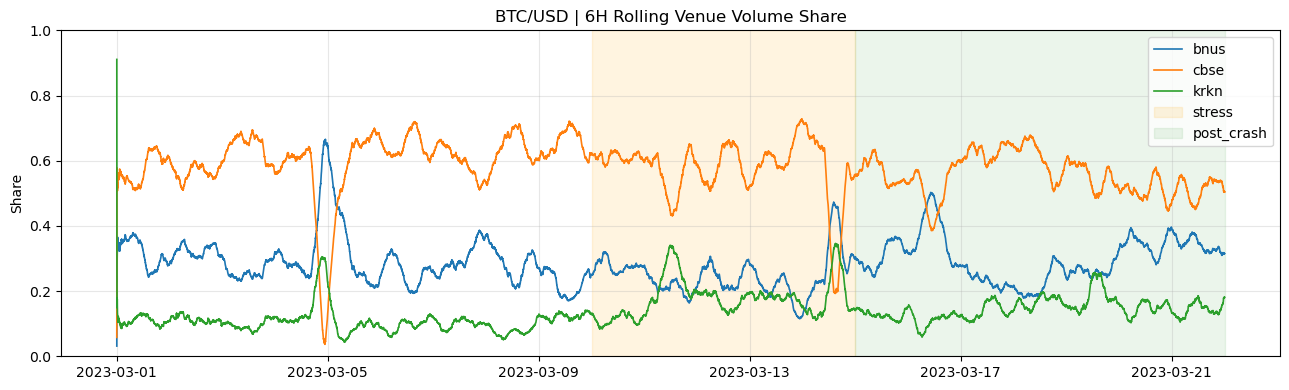

/var/folders/wq/jpl7wl6j5cl81szg3y7w20h40000gn/T/ipykernel_30849/2851070491.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  w = w[venues].rolling("6H").mean()  # smooth


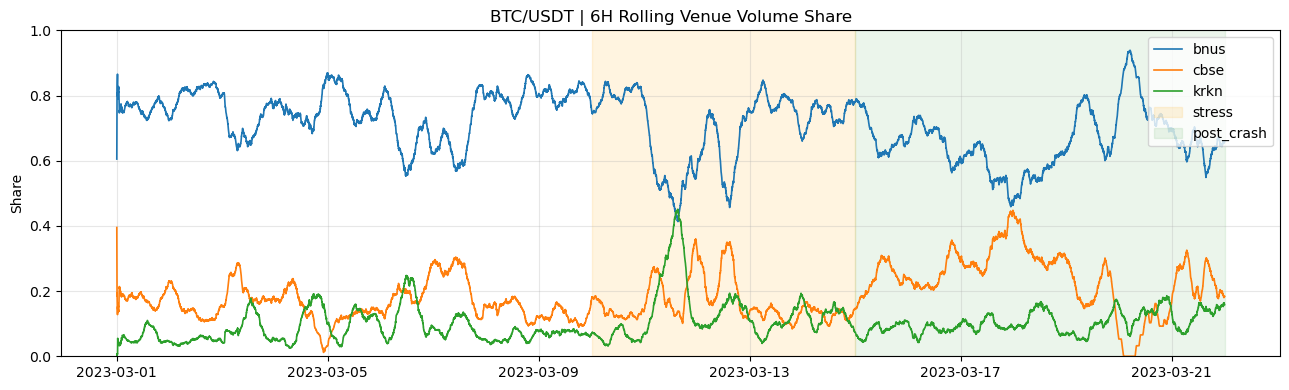

/var/folders/wq/jpl7wl6j5cl81szg3y7w20h40000gn/T/ipykernel_30849/2851070491.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  w = w[venues].rolling("6H").mean()  # smooth


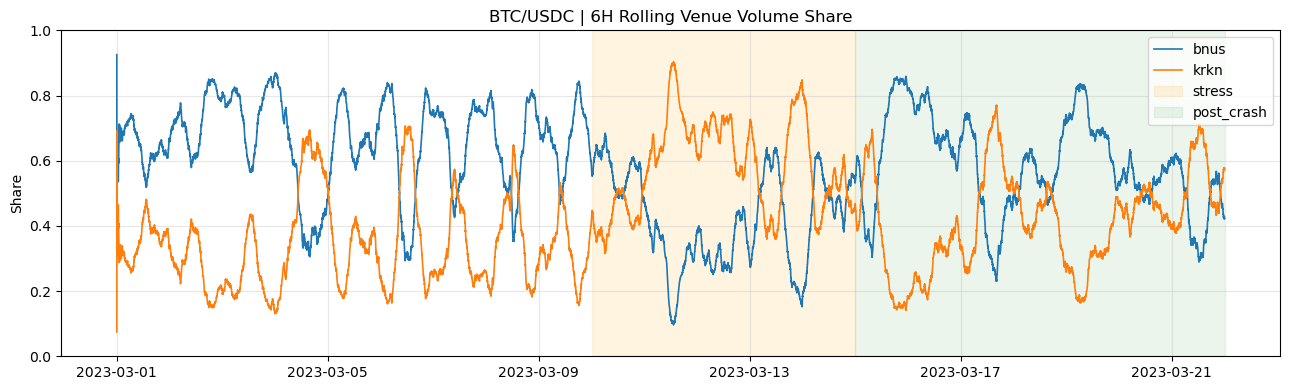

In [8]:
def shade_regimes(ax):
    ax.axvspan(pd.Timestamp("2023-03-10T00:00:00Z"), pd.Timestamp("2023-03-14T23:59:59Z"), alpha=0.12, color="orange", label="stress")
    ax.axvspan(pd.Timestamp("2023-03-15T00:00:00Z"), pd.Timestamp("2023-03-21T23:59:59Z"), alpha=0.08, color="green", label="post_crash")

for pair, venues in PAIR_VENUE_MAP.items():
    d = shares_df[shares_df["pair"] == pair].copy()
    w = d.pivot_table(index="time_bin", columns="exchange", values="share", aggfunc="mean").sort_index()
    w = w[venues].rolling("6H").mean()  # smooth

    fig, ax = plt.subplots(figsize=(13, 4))
    for ex in venues:
        ax.plot(w.index, w[ex], label=ex, linewidth=1.2)
    shade_regimes(ax)
    ax.set_title(f"{pair} | 6H Rolling Venue Volume Share")
    ax.set_ylabel("Share")
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Assumption: A dominance shift is considered significant only if the dominant venue share changes by more than 5 percentage points.

In the three-exchange setting (bnus, cbse, krkn), volume fragmentation still shows mostly stable leadership during stress for BTC/USD and BTC/USDT, but with a stronger shift in BTC/USDC. For BTC/USD, Coinbase remains dominant across all regimes (59.99% calm, 57.56% stress, 55.41% post-crash), and the calm-to-stress change is -2.43 percentage points, which is insignificant under the 5-point threshold. For BTC/USDT, Binance remains dominant (75.20% calm, 70.40% stress, 65.85% post-crash); the calm-to-stress shift is -4.80 points (insignificant), while the post-crash decline versus calm is -9.35 points (significant), indicating meaningful rebalancing away from Binance but not a leadership reversal. The strongest structural shift appears in BTC/USDC (bnus vs krkn), where dominance flips from Binance in calm (67.76%) to Kraken in stress (58.23%), a significant crash-time migration, before partially reverting post-crash (Binance 59.21%). Overall, the evidence indicates that stress primarily widened pricing frictions, while large venue-share migration was concentrated in the USDC-quoted market rather than broad-based across all pairs.

In [ ]:

# Cross-Venue Dislocation (multi-venue)

explain_block(
    "Cross-venue dislocation (pairwise and aggregate).",
    "Trades data, 1-minute VWAP per venue. For 3 venues: all pairwise dislocations + mean/max pairwise per minute.",
    "Higher bps = weaker cross-venue integration; stress amplification indicates market friction."
)

from itertools import combinations

def dislocation_multi(trades_df, pair_venue_map, freq="1min"):
    pairwise_rows, agg_rows = [], []

    for pair, venues in pair_venue_map.items():
        d = trades_df[(trades_df["pair"] == pair) & (trades_df["exchange"].isin(venues))].copy()
        d["time_bin"] = d.index.floor(freq)
        d["notional"] = d["price"] * d["amount"]

        v = d.groupby(["time_bin", "exchange"], as_index=False).agg(notional=("notional", "sum"), vol=("amount", "sum"))
        v["vwap"] = np.where(v["vol"] > 0, v["notional"] / v["vol"], np.nan)
        w = v.pivot(index="time_bin", columns="exchange", values="vwap").sort_index()

        bps_cols = []
        for a, b in combinations(venues, 2):
            z = w[[a, b]].dropna().copy()
            z["abs_bps"] = ((z[a] - z[b]).abs() / ((z[a] + z[b]) / 2.0)) * 10000.0
            z["pair"] = pair
            z["venue_pair"] = f"{a}-{b}"
            z = add_regime_labels(z)
            z = z[z["regime"] != "out_of_scope"]
            pairwise_rows.append(z[["pair", "venue_pair", "regime", "abs_bps"]])

            w[f"bps_{a}_{b}"] = ((w[a] - w[b]).abs() / ((w[a] + w[b]) / 2.0)) * 10000.0
            bps_cols.append(f"bps_{a}_{b}")

        # aggregate across all available venue pairs each minute
        if bps_cols:
            m = w[bps_cols].copy()
            m["pair"] = pair
            m["mean_pairwise_bps"] = m[bps_cols].mean(axis=1, skipna=True)
            m["max_pairwise_bps"] = m[bps_cols].max(axis=1, skipna=True)
            m = m.dropna(subset=["mean_pairwise_bps"])
            m["time_bin"] = m.index
            m = add_regime_labels(m, ts_col="time_bin")
            m = m[m["regime"] != "out_of_scope"]
            agg_rows.append(m[["pair", "regime", "mean_pairwise_bps", "max_pairwise_bps"]])

    pairwise_df = pd.concat(pairwise_rows, ignore_index=True)
    pairwise_summary = (
        pairwise_df.groupby(["pair", "venue_pair", "regime"], as_index=False)["abs_bps"]
        .agg(mean_bps="mean", median_bps="median", p90_bps=lambda x: np.nanpercentile(x, 90), max_bps="max", n_minutes="count")
        .sort_values(["pair", "venue_pair", "regime"])
    )

    agg_df = pd.concat(agg_rows, ignore_index=True)
    agg_summary = (
        agg_df.groupby(["pair", "regime"], as_index=False)
        .agg(
            mean_pairwise_bps=("mean_pairwise_bps", "mean"),
            p90_pairwise_bps=("mean_pairwise_bps", lambda x: np.nanpercentile(x, 90)),
            max_pairwise_bps=("max_pairwise_bps", "max"),
            n_minutes=("mean_pairwise_bps", "count"),
        )
        .sort_values(["pair", "regime"])
    )
    return pairwise_df, pairwise_summary, agg_summary

disloc_pairwise_df, disloc_pairwise_summary_df, disloc_agg_summary_df = dislocation_multi(
    trades_all, PAIR_VENUE_MAP, freq="1min"
)

display(disloc_agg_summary_df)
display(disloc_pairwise_summary_df)



Cross-venue dislocation (pairwise and aggregate).
Data used: Trades data, 1-minute VWAP per venue. For 3 venues: all pairwise dislocations + mean/max pairwise per minute.
How to gauge: Higher bps = weaker cross-venue integration; stress amplification indicates market friction.



,pair,regime,mean_pairwise_bps,p90_pairwise_bps,max_pairwise_bps,n_minutes
0,BTC/USD,calm,1.566968,3.111639,28.330500,12958
1,BTC/USD,post_crash,5.820298,12.722516,55.085542,10080
2,BTC/USD,stress,7.792076,16.219770,89.718752,7200
3,BTC/USDC,calm,3.454082,7.513094,33.048637,2880
4,BTC/USDC,post_crash,5.984644,13.074973,37.444102,3487
5,BTC/USDC,stress,52.041512,111.170901,1149.812642,3587
6,BTC/USDT,calm,1.686732,3.586998,37.031911,11790
7,BTC/USDT,post_crash,3.292007,6.410835,127.811305,9406
8,BTC/USDT,stress,3.751830,7.550128,72.796256,7035


,pair,venue_pair,regime,mean_bps,median_bps,p90_bps,max_bps,n_minutes
0,BTC/USD,bnus-cbse,calm,1.008475,0.743170,2.084722,28.330500,12609
1,BTC/USD,bnus-cbse,post_crash,4.475834,2.802169,11.237027,47.140600,10080
2,BTC/USD,bnus-cbse,stress,9.435923,6.029959,22.530663,89.718752,6946
3,BTC/USD,bnus-krkn,calm,1.970601,1.467701,4.257277,22.934592,12841
4,BTC/USD,bnus-krkn,post_crash,6.804190,4.585623,16.459491,44.344355,10068
5,BTC/USD,bnus-krkn,stress,8.357890,5.683875,19.627024,61.462253,7199
6,BTC/USD,cbse-krkn,calm,1.727062,1.225826,3.894326,22.572635,12632
7,BTC/USD,cbse-krkn,post_crash,6.169567,3.564603,17.493091,55.085542,10068
8,BTC/USD,cbse-krkn,stress,5.429463,3.654686,12.313818,59.455448,6947
9,BTC/USDC,bnus-krkn,calm,3.454082,2.543164,7.513094,33.048637,2880


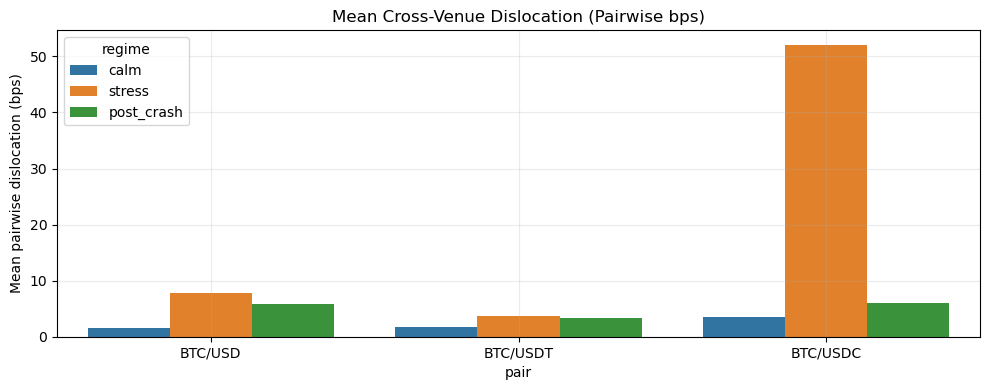

In [ ]:

# Dislocation regime comparison (aggregate)

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=disloc_agg_summary_df,
    x="pair",
    y="mean_pairwise_bps",
    hue="regime",
    order=["BTC/USD", "BTC/USDT", "BTC/USDC"],
    hue_order=["calm", "stress", "post_crash"],
    ax=ax
)
ax.set_title("Mean Cross-Venue Dislocation (Pairwise bps)")
ax.set_ylabel("Mean pairwise dislocation (bps)")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Cross-venue dislocation clearly worsens during stress in the three-exchange setup, and the strongest damage remains in BTC/USD (with the most extreme break in BTC/USDC). For BTC/USD, aggregate mean pairwise dislocation rises from 1.57 bps in calm to 7.79 bps in stress (about 5.0x), confirming a material divergence in cross-venue prices when markets were under pressure. Post-crash conditions improve relative to stress but remain above calm (mean 5.82 bps), which indicates incomplete reintegration.

For BTC/USDT, stress dislocation also increases but at a lower magnitude: mean rises from 1.69 to 3.75 bps (about 2.2x), with post-crash still elevated at 3.29 bps. For BTC/USDC (bnus-krkn), the stress effect is much larger: mean dislocation jumps from 3.45 to 52.04 bps (about 15x), then declines to 5.98 bps post-crash. The key takeaway is that stress primarily damaged cross-venue price integration, with the sharpest breakdown in USDC-quoted markets and a strong but smaller breakdown in USD-quoted markets.


In [ ]:

# Price Discovery (multi-venue pairwise lag-corr + Granger)

explain_block(
    "Price discovery across exchange pairs (lag-correlation + Granger).",
    "OHLC close prices, resampled to 1-minute returns; tested pairwise across venue combinations.",
    "best_lag=0 => synchronous minute updates; Granger p<0.05 => predictive information flow in that direction."
)

warnings.filterwarnings(
    "ignore",
    message="verbose is deprecated since functions should not print results",
    category=FutureWarning
)

def price_discovery_multi(ohlc_df, pair_venue_map, freq="1min", max_lag=5):
    rows = []

    for pair, venues in pair_venue_map.items():
        d = ohlc_df[(ohlc_df["pair"] == pair) & (ohlc_df["exchange"].isin(venues))].copy()
        d["time_bin"] = d.index.floor(freq)
        close_1m = d.groupby(["time_bin", "exchange"], as_index=False)["close"].last()
        w = close_1m.pivot(index="time_bin", columns="exchange", values="close").sort_index()

        for a, b in combinations(venues, 2):
            x = w[[a, b]].dropna().copy()
            x["ret_a"] = np.log(x[a]).diff()
            x["ret_b"] = np.log(x[b]).diff()
            x = x.dropna(subset=["ret_a", "ret_b"])
            x = add_regime_labels(x)
            x = x[x["regime"] != "out_of_scope"]

            for rg in ["calm", "stress", "post_crash"]:
                y = x[x["regime"] == rg]
                if y.empty:
                    continue

                # best lag corr
                best_lag, best_corr = None, None
                for lag in range(-max_lag, max_lag + 1):
                    c = y["ret_a"].corr(y["ret_b"].shift(lag))
                    if pd.isna(c):
                        continue
                    if best_corr is None or abs(c) > abs(best_corr):
                        best_corr, best_lag = c, lag

                # Granger both directions
                if len(y) >= 200:
                    r_b_to_a = grangercausalitytests(y[["ret_a", "ret_b"]], maxlag=max_lag, verbose=False)
                    p_b_to_a = min(r_b_to_a[L][0]["ssr_ftest"][1] for L in range(1, max_lag + 1))

                    r_a_to_b = grangercausalitytests(y[["ret_b", "ret_a"]], maxlag=max_lag, verbose=False)
                    p_a_to_b = min(r_a_to_b[L][0]["ssr_ftest"][1] for L in range(1, max_lag + 1))
                else:
                    p_b_to_a, p_a_to_b = np.nan, np.nan

                rows.append({
                    "pair": pair,
                    "venue_pair": f"{a}-{b}",
                    "regime": rg,
                    "best_lag_min": best_lag,
                    "best_corr": best_corr,
                    "p_b_to_a_min": p_b_to_a,
                    "p_a_to_b_min": p_a_to_b,
                    "n_obs": len(y),
                })

    out = pd.DataFrame(rows).sort_values(["pair", "venue_pair", "regime"])
    return out

pd_summary_df = price_discovery_multi(ohlc_all, PAIR_VENUE_MAP, freq="1min", max_lag=5)
display(pd_summary_df)



Price discovery across exchange pairs (lag-correlation + Granger).
Data used: OHLC close prices, resampled to 1-minute returns; tested pairwise across venue combinations.
How to gauge: best_lag=0 => synchronous minute updates; Granger p<0.05 => predictive information flow in that direction.



,pair,venue_pair,regime,best_lag_min,best_corr,p_b_to_a_min,p_a_to_b_min,n_obs
0,BTC/USD,bnus-cbse,calm,0,0.972470,8.890059e-32,7.120773e-06,12608
2,BTC/USD,bnus-cbse,post_crash,0,0.975858,2.543385e-14,8.216945e-06,10080
1,BTC/USD,bnus-cbse,stress,0,0.973928,7.362305e-04,3.092039e-02,6946
3,BTC/USD,bnus-krkn,calm,0,0.863321,1.426481e-07,1.324225e-180,12840
5,BTC/USD,bnus-krkn,post_crash,0,0.925718,3.436710e-04,7.047195e-92,10068
4,BTC/USD,bnus-krkn,stress,0,0.908963,1.746790e-02,3.962230e-65,7199
6,BTC/USD,cbse-krkn,calm,0,0.870160,7.512937e-04,1.247494e-195,12631
8,BTC/USD,cbse-krkn,post_crash,0,0.929365,6.182773e-02,2.783031e-101,10068
7,BTC/USD,cbse-krkn,stress,0,0.933230,1.068276e-02,3.570315e-47,6947
18,BTC/USDC,bnus-krkn,calm,0,0.821595,1.262001e-03,7.251038e-64,2879


Price discovery in the three-exchange setting still indicates fast transmission at the 1-minute horizon, with stress showing up more in directional asymmetry than in timing delays. Lag-correlation results keep a best lag of 0 across pairs and venue combinations, implying no clear minute-level delay in price adjustment. Contemporaneous co-movement remains high for BTC/USD (bnus-cbse around 0.97; bnus-krkn and cbse-krkn rising into roughly 0.91–0.93 in stress/post-crash), while BTC/USDT is slightly lower but still strong (about 0.77–0.91 depending on venue pair and regime).

Granger results provide the directional detail: BTC/USD is largely bidirectional across regimes, but flow into Kraken is often statistically stronger than the reverse direction. For BTC/USDT, the key stress asymmetry persists in bnus-cbse: Binance -> Coinbase remains strongly significant, while Coinbase -> Binance becomes insignificant in stress (p ≈ 0.175), indicating Binance-led information flow under pressure. For BTC/USDC (bnus-krkn), contemporaneous correlation drops sharply in stress (to about 0.34) even though Granger remains significant both ways, showing that stress can weaken synchronous alignment without eliminating predictive linkage. Overall, prices move together in real time, but stress redistributes influence and weakens integration quality in a pair-dependent way.

In [ ]:

# Cross-Currency Basis Analysis (exchange-specific costs)

explain_block(
    "Cross-currency basis (BTC/USDT vs BTC/USD)",
    "OHLC close prices, 1-minute frequency, exchanges: bnus/cbse/krkn",
    "Near-zero basis = parity; large/persistent |basis| and above-cost episodes = meaningful cross-currency friction."
)

# CONFIG
REF_PAIR = "BTC/USD"
Q_PAIR = "BTC/USDT"
EXCHANGES = ["bnus", "cbse", "krkn"]  

# Assumed fee tiers (bps per fill)
FEE_BPS = {
    "bnus": {"maker": 0.0,  "taker": 1.0},
    "cbse": {"maker": 15.0, "taker": 25.0},
    "krkn": {"maker": 12.0, "taker": 22.0},
}

FEE_MODE = "taker"          # "taker" or "maker"
EXTRA_FRICTION_BPS = 10.0    #slippage/latency buffer 
MAX_LAG_HAC = 5             # HAC lag for regression standard errors


# BASIS PANEL 
d = ohlc_all[
    (ohlc_all["pair"].isin([REF_PAIR, Q_PAIR])) &
    (ohlc_all["exchange"].isin(EXCHANGES))
].copy()

d["time_bin"] = d.index.floor("1min")
close_1m = d.groupby(["time_bin", "exchange", "pair"], as_index=False)["close"].last()

basis_ts_df = close_1m.pivot(index=["time_bin", "exchange"], columns="pair", values="close").reset_index()
basis_ts_df = basis_ts_df.dropna(subset=[REF_PAIR, Q_PAIR]).copy()

basis_ts_df["basis_bps"] = ((basis_ts_df[Q_PAIR] - basis_ts_df[REF_PAIR]) / basis_ts_df[REF_PAIR]) * 10000.0
basis_ts_df["abs_basis_bps"] = basis_ts_df["basis_bps"].abs()
basis_ts_df = add_regime_labels(basis_ts_df, ts_col="time_bin")
basis_ts_df = basis_ts_df[basis_ts_df["regime"] != "out_of_scope"].copy()

# REGIME SUMMARY 
basis_summary_df = (
    basis_ts_df.groupby(["exchange", "regime"], as_index=False)
    .agg(
        mean_basis_bps=("basis_bps", "mean"),
        median_basis_bps=("basis_bps", "median"),
        p90_abs_basis_bps=("abs_basis_bps", lambda x: np.nanpercentile(x, 90)),
        max_abs_basis_bps=("abs_basis_bps", "max"),
        n_minutes=("basis_bps", "count"),
    )
    .sort_values(["exchange", "regime"])
)

# EXCHANGE + REGIME SPECIFIC COSTS
# round-trip two-leg (4 fills) + regime-dependent friction

FEE_TAKER_BPS = {
    "bnus": 1.0,   # Binance 0.01% (BTC/USD and BTC/USDT are both tier-0 pairs)
    "cbse": 25.0,  # Coinbase assumed tier (50-100K monthly volume)
    "krkn": 22.0,  # Kraken assumed tier (100K monthly volume)
}

def extra_friction_bps(regime):
    # your chosen regime-specific friction
    if regime == "stress":
        return 25.0   # stress = higher slippage/latency
    return 12.0       # calm + post_crash

basis_cost_df = basis_ts_df.copy()
basis_cost_df["fee_component_bps"] = 4.0 * basis_cost_df["exchange"].map(FEE_TAKER_BPS)
basis_cost_df["extra_friction_bps"] = basis_cost_df["regime"].map(extra_friction_bps)
basis_cost_df["cost_bps"] = basis_cost_df["fee_component_bps"] + basis_cost_df["extra_friction_bps"]

basis_cost_df["net_edge_bps"] = basis_cost_df["abs_basis_bps"] - basis_cost_df["cost_bps"]
basis_cost_df["above_cost"] = basis_cost_df["net_edge_bps"] > 0

# updated summary
basis_cost_summary_df = (
    basis_cost_df.groupby(["exchange", "regime"], as_index=False)
    .agg(
        mean_abs_basis_bps=("abs_basis_bps", "mean"),
        mean_fee_component_bps=("fee_component_bps", "mean"),
        mean_extra_friction_bps=("extra_friction_bps", "mean"),
        mean_cost_bps=("cost_bps", "mean"),
        pct_minutes_above_cost=("above_cost", "mean"),
        mean_net_edge_bps=("net_edge_bps", "mean"),
        n_minutes=("basis_bps", "count"),
    )
    .sort_values(["exchange", "regime"])
)
basis_cost_summary_df["pct_minutes_above_cost"] *= 100.0

display(basis_cost_summary_df)

# PERSISTENCE EPISODES 
eps_rows = []
for (ex, rg), g in basis_cost_df.sort_values(["exchange", "time_bin"]).groupby(["exchange", "regime"]):
    h = g.copy()
    h["grp"] = (h["above_cost"] != h["above_cost"].shift(1)).cumsum()
    e = h[h["above_cost"]].groupby("grp", as_index=False).agg(duration_min=("above_cost", "size"))
    if len(e) == 0:
        eps_rows.append({
            "exchange": ex, "regime": rg,
            "n_episodes": 0, "mean_duration_min": 0.0,
            "p90_duration_min": 0.0, "max_duration_min": 0.0
        })
    else:
        eps_rows.append({
            "exchange": ex, "regime": rg,
            "n_episodes": int(len(e)),
            "mean_duration_min": float(e["duration_min"].mean()),
            "p90_duration_min": float(np.nanpercentile(e["duration_min"], 90)),
            "max_duration_min": float(e["duration_min"].max()),
        })

basis_episode_summary_df = pd.DataFrame(eps_rows).sort_values(["exchange", "regime"])

# CROSS-VENUE BASIS DISPERSION 
basis_wide = basis_ts_df.pivot(index="time_bin", columns="exchange", values="basis_bps")
basis_disp_ts_df = pd.DataFrame({
    "time_bin": basis_wide.index,
    "basis_std_across_venues": basis_wide.std(axis=1, skipna=True)
})
basis_disp_ts_df = add_regime_labels(basis_disp_ts_df, ts_col="time_bin")
basis_disp_ts_df = basis_disp_ts_df[basis_disp_ts_df["regime"] != "out_of_scope"]

basis_disp_summary_df = (
    basis_disp_ts_df.groupby("regime", as_index=False)["basis_std_across_venues"]
    .agg(
        mean_std_bps="mean",
        median_std_bps="median",
        p90_std_bps=lambda x: np.nanpercentile(x, 90),
        max_std_bps="max",
        n_minutes="count",
    )
)

# DRIVER REGRESSION FOR |BASIS|
# Driver 1: regime dummies
# Driver 2: cross-venue BTC/USD dislocation proxy (mean pairwise bps by minute)
# Driver 3: 1-min abs return on BTC/USD (volatility proxy)
def build_dislocation_proxy(ohlc_df, pair="BTC/USD", exchanges=None):
    x = ohlc_df[(ohlc_df["pair"] == pair)].copy()
    if exchanges is not None:
        x = x[x["exchange"].isin(exchanges)].copy()
    x["time_bin"] = x.index.floor("1min")
    p = x.groupby(["time_bin", "exchange"], as_index=False)["close"].last().pivot(index="time_bin", columns="exchange", values="close")

    rows = []
    cols = list(p.columns)
    from itertools import combinations
    for t, r in p.iterrows():
        z = r.dropna()
        if len(z) < 2:
            rows.append((t, np.nan))
            continue
        bps = []
        for a, b in combinations(z.index, 2):
            bps.append(abs(z[a] - z[b]) / ((z[a] + z[b]) / 2.0) * 10000.0)
        rows.append((t, float(np.mean(bps))))
    return pd.DataFrame(rows, columns=["time_bin", "mean_pairwise_disloc_bps"])

disloc_proxy_df = build_dislocation_proxy(ohlc_all, pair=REF_PAIR, exchanges=EXCHANGES)

reg_rows = []
for ex, g in basis_ts_df.groupby("exchange"):
    z = g.copy().sort_values("time_bin")
    z["ret_ref"] = np.log(z[REF_PAIR]).diff()
    z["abs_ret_ref_bps"] = z["ret_ref"].abs() * 10000.0
    z = z.merge(disloc_proxy_df, on="time_bin", how="left")

    z["is_stress"] = (z["regime"] == "stress").astype(int)
    z["is_post"] = (z["regime"] == "post_crash").astype(int)

    use_cols = ["is_stress", "is_post", "mean_pairwise_disloc_bps", "abs_ret_ref_bps"]
    zz = z.dropna(subset=["abs_basis_bps"] + use_cols).copy()

    if len(zz) < 300:
        reg_rows.append({"exchange": ex, "n_obs": len(zz), "note": "insufficient rows"})
        continue

    Y = zz["abs_basis_bps"]
    X = sm.add_constant(zz[use_cols])
    m = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": MAX_LAG_HAC})

    row = {"exchange": ex, "n_obs": int(m.nobs), "adj_r2": float(m.rsquared_adj)}
    for c in use_cols:
        row[f"coef_{c}"] = float(m.params[c])
        row[f"p_{c}"] = float(m.pvalues[c])
    reg_rows.append(row)

basis_driver_df = pd.DataFrame(reg_rows)


print("Cost map used (bps):", cost_map)
display(basis_summary_df)
display(basis_cost_summary_df)
display(basis_episode_summary_df)
display(basis_disp_summary_df)
display(basis_driver_df)





Cross-currency basis (BTC/USDT vs BTC/USD), complete analysis.
Data used: OHLC close prices, 1-minute frequency, exchanges: bnus/cbse/krkn where available.
How to gauge: Near-zero basis = parity; large/persistent |basis| and above-cost episodes = meaningful cross-currency friction.



,exchange,regime,mean_abs_basis_bps,mean_fee_component_bps,mean_extra_friction_bps,mean_cost_bps,pct_minutes_above_cost,mean_net_edge_bps,n_minutes
0,bnus,calm,1.560752,4.0,12.0,16.0,0.032188,-14.439248,12427
1,bnus,post_crash,27.450495,4.0,12.0,16.0,87.398578,11.450495,9983
2,bnus,stress,45.726124,4.0,25.0,29.0,62.791351,16.726124,7122
3,cbse,calm,1.768498,100.0,12.0,112.0,0.000000,-110.231502,11005
4,cbse,post_crash,30.796688,100.0,12.0,112.0,0.000000,-81.203312,8103
5,cbse,stress,54.503401,100.0,25.0,125.0,3.249042,-70.496599,6525
6,krkn,calm,2.766762,88.0,12.0,100.0,0.000000,-97.233238,7397
7,krkn,post_crash,26.451118,88.0,12.0,100.0,0.000000,-73.548882,7165
8,krkn,stress,51.145508,88.0,25.0,113.0,5.214567,-61.854492,5849


Cost map used (bps): {'bnus': 14.0, 'cbse': 110.0, 'krkn': 98.0}


,exchange,regime,mean_basis_bps,median_basis_bps,p90_abs_basis_bps,max_abs_basis_bps,n_minutes
0,bnus,calm,-0.113514,-0.134149,3.373055,30.709821,12427
1,bnus,post_crash,-27.445216,-28.071351,38.293703,75.078273,9983
2,bnus,stress,-45.495209,-38.718970,92.912139,163.170350,7122
3,cbse,calm,-0.192528,-0.247785,3.809045,29.909632,11005
4,cbse,post_crash,-30.796673,-30.069626,41.497945,73.368271,8103
5,cbse,stress,-54.129083,-49.876450,108.987431,184.230922,6525
6,krkn,calm,-0.431331,-0.357274,6.143044,37.292394,7397
7,krkn,post_crash,-26.440606,-26.286680,38.790529,71.190499,7165
8,krkn,stress,-50.435648,-45.195062,101.998317,166.797100,5849


,exchange,regime,mean_abs_basis_bps,mean_fee_component_bps,mean_extra_friction_bps,mean_cost_bps,pct_minutes_above_cost,mean_net_edge_bps,n_minutes
0,bnus,calm,1.560752,4.0,12.0,16.0,0.032188,-14.439248,12427
1,bnus,post_crash,27.450495,4.0,12.0,16.0,87.398578,11.450495,9983
2,bnus,stress,45.726124,4.0,25.0,29.0,62.791351,16.726124,7122
3,cbse,calm,1.768498,100.0,12.0,112.0,0.000000,-110.231502,11005
4,cbse,post_crash,30.796688,100.0,12.0,112.0,0.000000,-81.203312,8103
5,cbse,stress,54.503401,100.0,25.0,125.0,3.249042,-70.496599,6525
6,krkn,calm,2.766762,88.0,12.0,100.0,0.000000,-97.233238,7397
7,krkn,post_crash,26.451118,88.0,12.0,100.0,0.000000,-73.548882,7165
8,krkn,stress,51.145508,88.0,25.0,113.0,5.214567,-61.854492,5849


,exchange,regime,n_episodes,mean_duration_min,p90_duration_min,max_duration_min
0,bnus,calm,3,1.333333,1.8,2.0
1,bnus,post_crash,266,32.800752,14.5,1612.0
2,bnus,stress,147,30.421769,23.0,2638.0
3,cbse,calm,0,0.000000,0.0,0.0
4,cbse,post_crash,0,0.000000,0.0,0.0
5,cbse,stress,23,9.217391,16.6,137.0
6,krkn,calm,0,0.000000,0.0,0.0
7,krkn,post_crash,0,0.000000,0.0,0.0
8,krkn,stress,46,6.630435,7.5,158.0


,regime,mean_std_bps,median_std_bps,p90_std_bps,max_std_bps,n_minutes
0,calm,1.661431,1.293264,3.455400,22.511413,11761
1,post_crash,5.095579,4.038225,10.931580,28.883104,9406
2,stress,6.539400,5.027514,13.744603,46.015222,7024


,exchange,n_obs,adj_r2,coef_is_stress,p_is_stress,coef_is_post,p_is_post,coef_mean_pairwise_disloc_bps,p_mean_pairwise_disloc_bps,coef_abs_ret_ref_bps,p_abs_ret_ref_bps
0,bnus,29531,0.503725,42.008845,1.095024e-293,24.525495,0.0,0.446216,5.917007e-08,-0.128682,0.000066
1,cbse,25632,0.591557,43.838394,2.037373e-275,22.867067,0.0,1.604088,3.496364e-66,-0.111592,0.000060
2,krkn,20409,0.510913,44.119699,1.106745e-268,20.957895,0.0,0.743974,2.586331e-16,-0.058476,0.036079


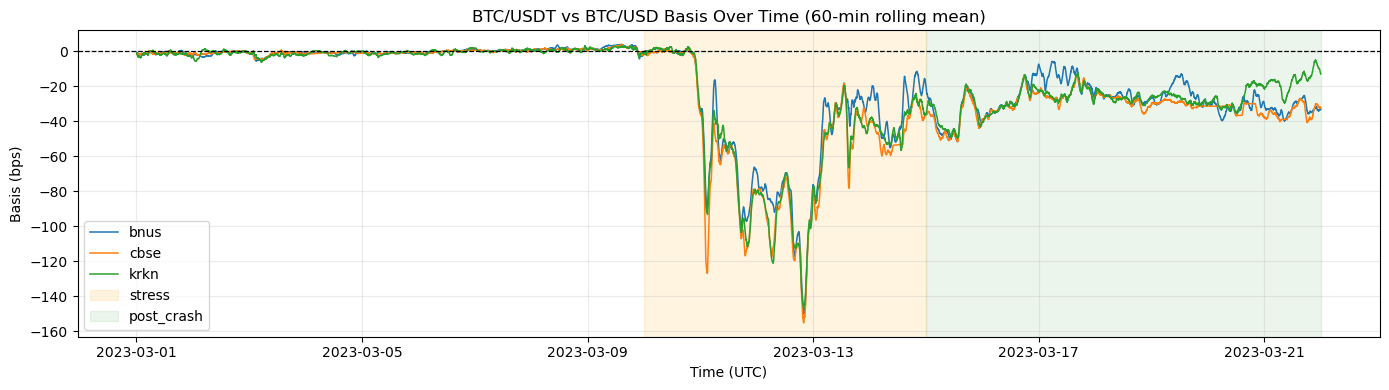

In [15]:
# ==========================================
# Basis Plot 1: Time series by exchange (with regime shading)
# Uses: basis_ts_df (must contain time_bin, exchange, basis_bps)
# ==========================================

def shade_regimes(ax):
    ax.axvspan(pd.Timestamp("2023-03-10T00:00:00Z"), pd.Timestamp("2023-03-14T23:59:59Z"),
               color="orange", alpha=0.12, label="stress")
    ax.axvspan(pd.Timestamp("2023-03-15T00:00:00Z"), pd.Timestamp("2023-03-21T23:59:59Z"),
               color="green", alpha=0.08, label="post_crash")

fig, ax = plt.subplots(figsize=(14, 4))
for ex in sorted(basis_ts_df["exchange"].unique()):
    x = basis_ts_df[basis_ts_df["exchange"] == ex].sort_values("time_bin").copy()
    # smooth for readability
    x["basis_roll"] = x["basis_bps"].rolling(60, min_periods=10).mean()  # 60-min rolling mean
    ax.plot(x["time_bin"], x["basis_roll"], linewidth=1.1, label=ex)

shade_regimes(ax)
ax.axhline(0, color="black", linestyle="--", linewidth=0.9)
ax.set_title("BTC/USDT vs BTC/USD Basis Over Time (60-min rolling mean)")
ax.set_ylabel("Basis (bps)")
ax.set_xlabel("Time (UTC)")
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()


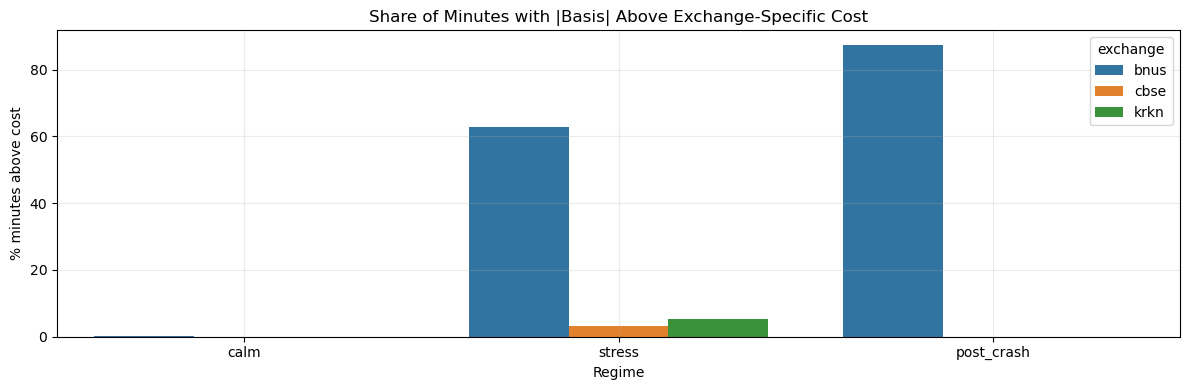

In [16]:
# ==========================================
# Basis Plot 3: % minutes above exchange-specific cost
# Uses: basis_cost_summary_df (exchange, regime, pct_minutes_above_cost)
# ==========================================
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    data=basis_cost_summary_df,
    x="regime",
    y="pct_minutes_above_cost",
    hue="exchange",
    order=["calm", "stress", "post_crash"],
    ax=ax
)
ax.set_title("Share of Minutes with |Basis| Above Exchange-Specific Cost")
ax.set_ylabel("% minutes above cost")
ax.set_xlabel("Regime")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


For transaction costs, we model a round-trip two-leg basis trade (BTC/USD leg + BTC/USDT leg; open + close = 4 fills) with exchange-specific taker fees (Binance 1 bps/fill, Coinbase 25 bps/fill, Kraken 22 bps/fill) and regime-dependent execution friction: 12 bps in calm/post-crash and 25 bps in stress. This yields exchange- and regime-specific thresholds rather than one flat cutoff, which is more consistent with observed stress-time microstructure conditions.

Before costs, basis is near parity in calm and widens sharply in stress across all venues (calm means close to zero: bnus -0.11 bps, cbse -0.19 bps, krkn -0.43 bps; stress means around -45 to -54 bps), with post-crash still materially negative. After costs, persistence remains highly venue-dependent: Binance still clears threshold frequently because fee burden is low, while Coinbase and Kraken require much larger wedges and therefore clear costs mainly in the largest stress windows. This confirms that basis stress is broad at the gross level, but economically tradable persistence depends strongly on venue fee architecture and execution frictions.

The driver regression is consistent with this interpretation: stress and post-crash dummies are strongly positive across venues, and cross-venue dislocation is also positively significant. In other words, basis widening is not random noise; it is systematically linked to stress regime and market-integration breakdown, with net realizability filtered by exchange-specific cost structure.


complete overview of volume fragmenatation, cross-venue dislocation, price discovery and corss-currency basis:

The three-exchange evidence (Binance, Coinbase, Kraken) reinforces the same core diagnosis with stronger cross-sectional support: the main stress failure was not participation collapse, but pricing and convertibility friction. Volume fragmentation shows that leadership was mostly stable in BTC/USD (Coinbase-led) and BTC/USDT (Binance-led), with limited calm-to-stress dominant-share shifts under the 5pp significance rule; the only clear crash-time reallocation appears in BTC/USDC, where dominance flips toward Kraken in stress. In contrast, price alignment metrics deteriorate sharply: cross-venue dislocation rises materially in stress for BTC/USD and BTC/USDT, and most severely for BTC/USDC. Price-discovery timing remains fast (best lag = 0), but directional asymmetry increases under stress, especially in BTC/USDT where Binance’s predictive influence dominates. Cross-currency basis then confirms the same mechanism: BTC/USDT vs BTC/USD moves from near parity in calm to large, persistent stress/post-crash wedges. Taken together, markets stayed active and connected at the minute horizon, yet parity enforcement weakened exactly where redemption confidence, settlement certainty, and quote-currency trust become binding.

From a policy perspective, this pattern is precisely why regulated stablecoins can alter trading behavior. When market participants have stronger confidence in reserve quality, redemption mechanics, and supervisory credibility, the stablecoin-specific risk premium embedded in cross-currency pricing should compress. In microstructure terms, that should reduce stress-time basis persistence, lower dislocation tails, and restore more symmetric information flow across venues. The GENIUS Act (enacted July 18, 2025) is directionally aligned with these empirical weaknesses: reserve and disclosure requirements, issuer oversight, and redemption clarity target the channels through which trust shocks became pricing wedges in March 2023. Payment-network settlement adoption (e.g., card-network stablecoin rails) strengthens this channel further by improving practical settlement continuity and accelerating convergence.

At the same time, our results imply a clear boundary on what regulation can do. GENIUS-type rules can reduce stablecoin credit-opacity risk, but they cannot eliminate exchange-level liquidity withdrawal, inventory constraints, latency, fee heterogeneity, or broader fiat-rail bottlenecks during stress. This is visible in exchange-specific cost-adjusted basis outcomes: gross wedges are broad, but net persistence differs sharply by venue because market structure and trading frictions differ. The right policy benchmark is therefore not “zero dislocation,” but a measurable shift toward fewer, smaller, and shorter stress-time wedges, plus faster post-shock reintegration across venues and quote currencies.